# Initialize notebook

In [6]:
import wandb

In [7]:
import lpips
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset

In [8]:
import sys
sys.path.append("/home/e/e0425222/CS4243-project")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import sample_batch, summary
from utils.train_utils.model_utils import LinearBlock

In [9]:
train_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_train.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

valid_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_val.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

test_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_test.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])


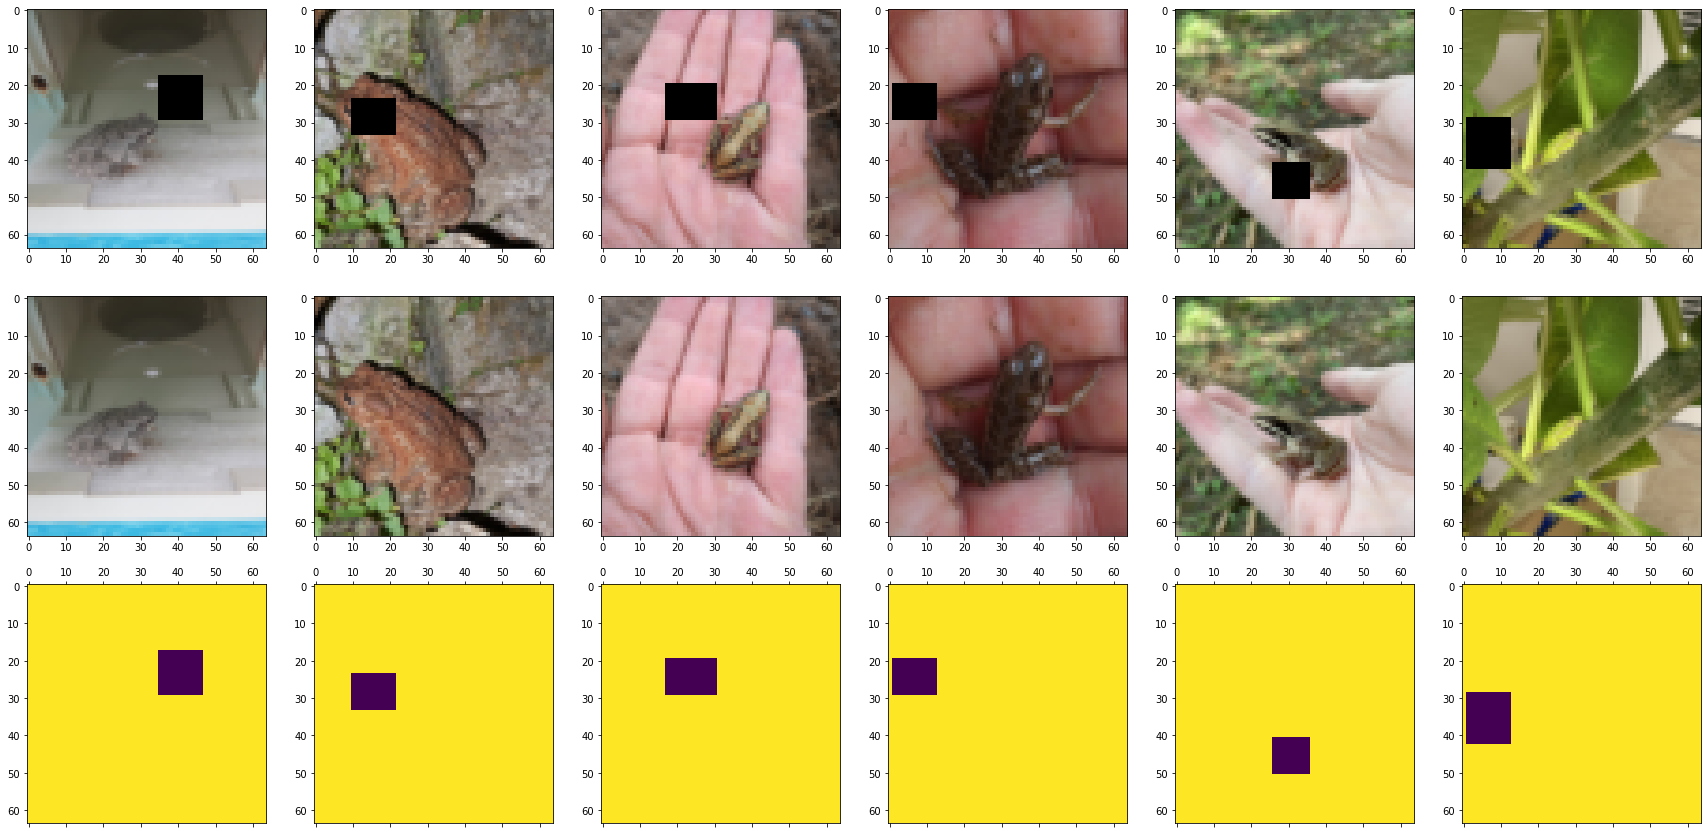

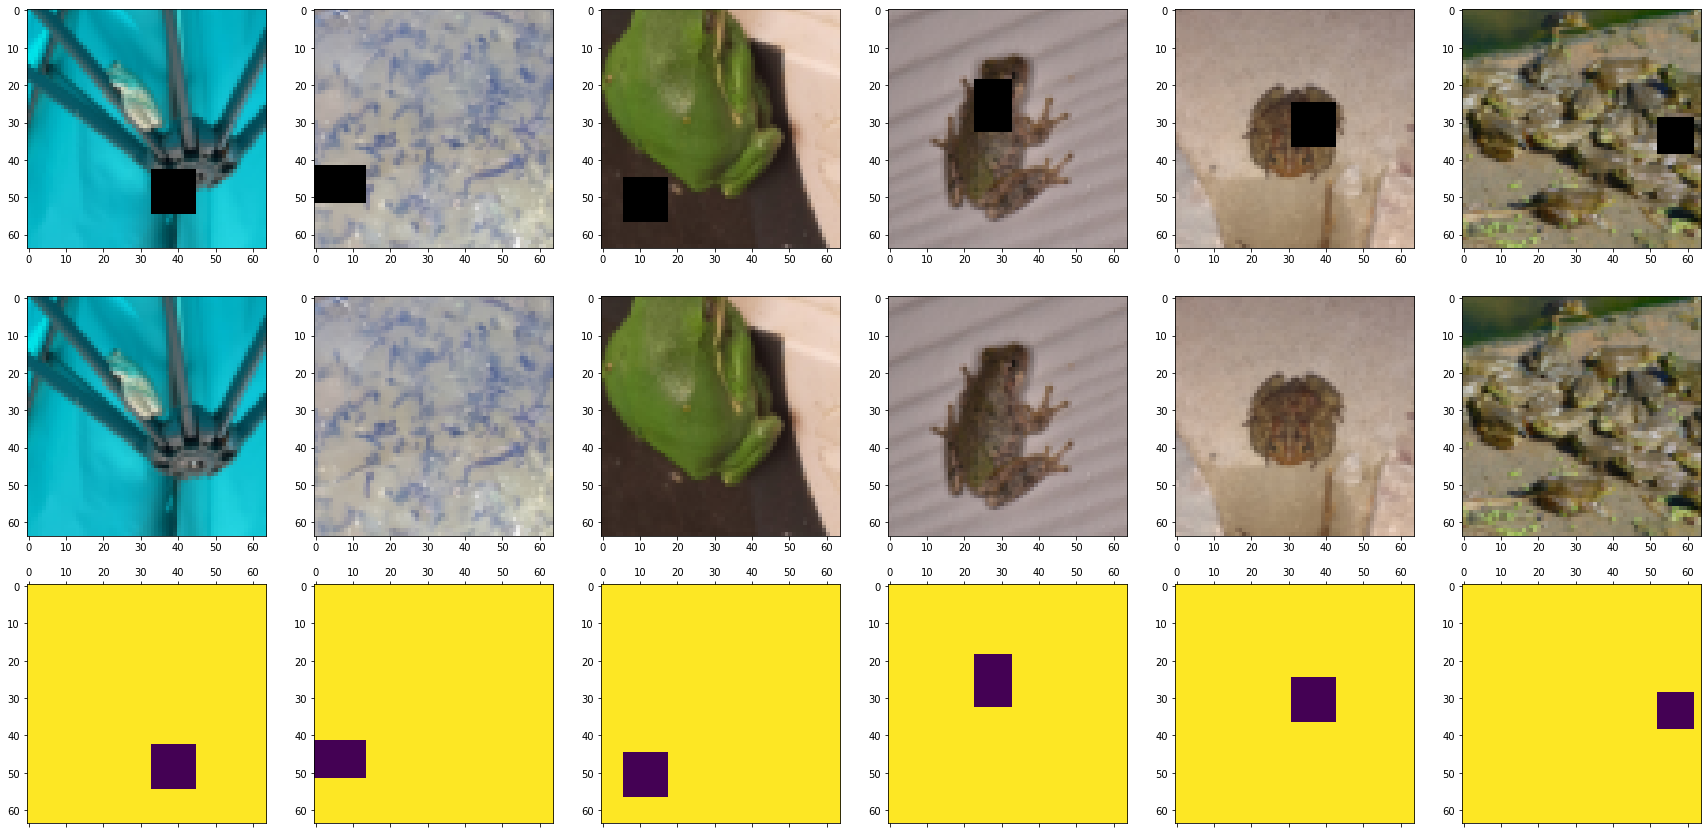

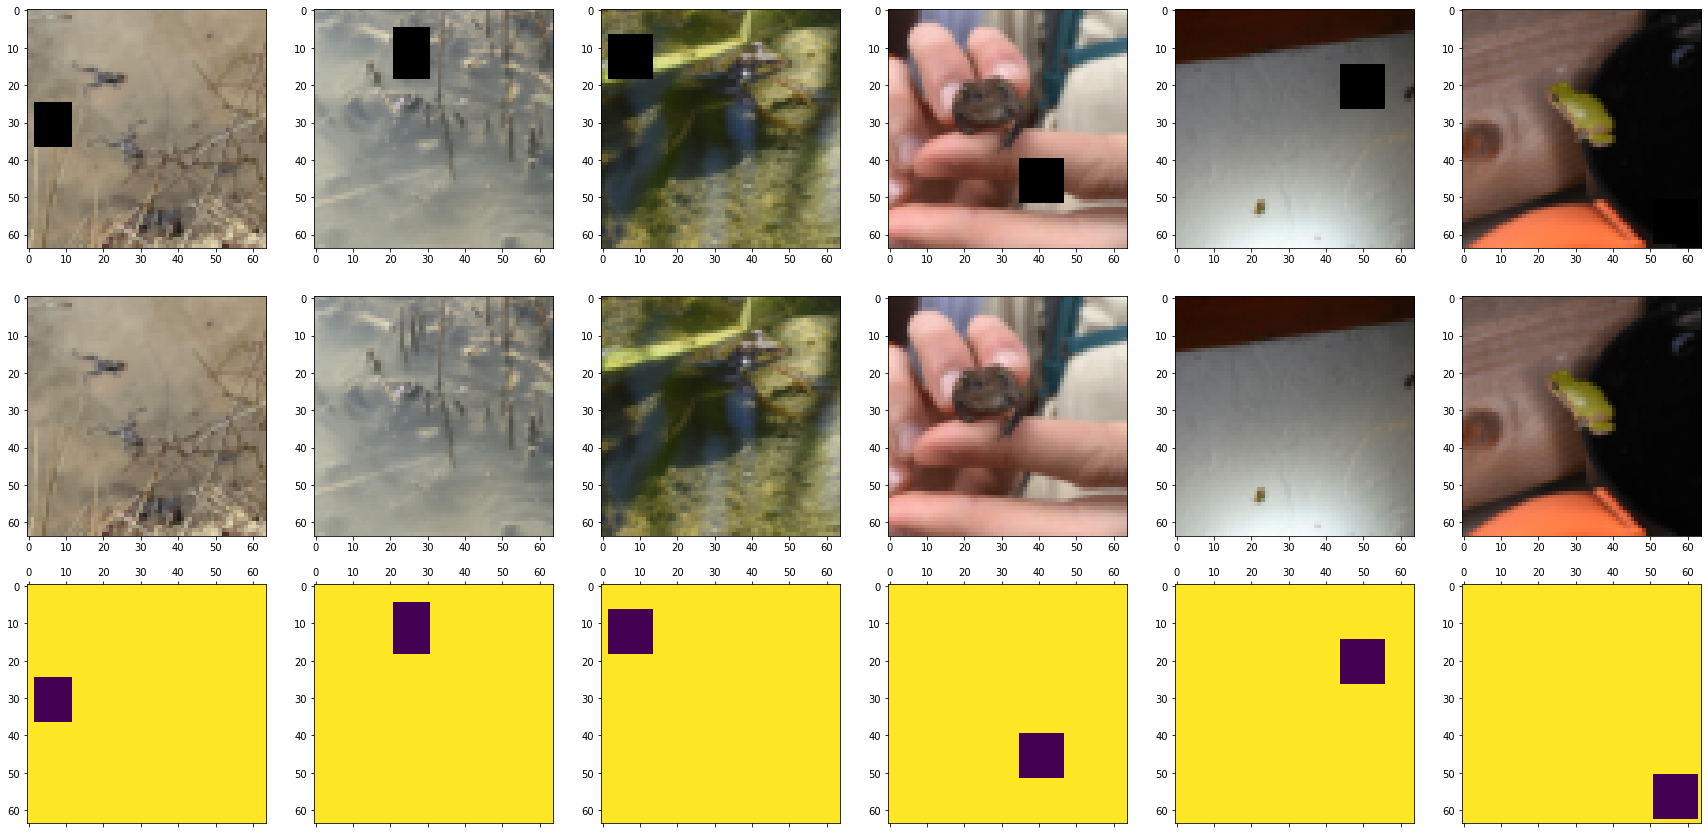

In [10]:
# sanity check 
sample_batch(train_dataset, sample_size = 6)
sample_batch(valid_dataset, sample_size = 6)
sample_batch(test_dataset, sample_size = 6)


# Introduction
This notebook aims to explore the MLP baseline model.

# Model experiment


In [20]:
class Generator(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, activation, image_shape):
        super(Generator, self).__init__()
        
        INPUT_DIM = image_shape * image_shape * input_dim
        OUTPUT_DIM = image_shape * image_shape * output_dim
        self.linear0 = LinearBlock(INPUT_DIM, hidden_dim, activation)
        self.linear1 = LinearBlock(hidden_dim, hidden_dim, activation)
        self.linear2 = LinearBlock(hidden_dim, hidden_dim, activation)
        self.final = nn.Linear(hidden_dim, OUTPUT_DIM)

    def forward(self, input_tensor):
        b, c, h, w = input_tensor.shape    
        x = input_tensor.reshape(b, c*h*w)
        x = self.linear0(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.final(x)
        x = x.reshape(b, 3, h, w)

        return x


# Training configuration

In [21]:
MODEL_PARAMS = {
    "description" : """
        5 layer MLP. 
        """,
    "hidden_dim" : 64,
    "activation" : nn.Mish,
}

SAVE_PATHS = {
    "generator" : "/home/e/e0425222/CS4243-project/active_experiments/Vanilla/MLP/generator/generator",
}

TRAINING_PARAMS = {
    "num_epochs" : 20,
    "batch_size" : 64, 
    "learning_rate": 1e-3,
    "schedule_every" : 5,
    "sample_size" : 16,
    "log_every" : 10,
    "save_paths" : SAVE_PATHS,
}

LOGGING_CONFIG = {
    "model_params" : MODEL_PARAMS,
}
LOGGING_CONFIG.update(TRAINING_PARAMS)

# Experiment intialization

In [22]:
# 1. initialize model
generator = Generator(input_dim = 4, hidden_dim = MODEL_PARAMS["hidden_dim"], output_dim = 3, activation = MODEL_PARAMS["activation"], image_shape = 64)

summary(generator)

# 2. device
parallel = True
device = 'cuda:0'  
devices = [0,1,2,3]

if not parallel:
    generator1 = generator.to(device)
else:
    generator1 = nn.DataParallel(generator, device_ids = devices)

# 3. initialize loss functions
recon_loss_function = lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'none').sum()/(1-mask).sum()

# 4. initialize metrics
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)
METRICS = {
    "Peak SnR (Whole)" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img * (1-mask) + gt * mask, gt),
    "L2 loss (Whole)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask) + gt * mask, gt),
    "L2 loss (Mask)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "L1 loss (Whole)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask) + gt * mask, gt),
    "L1 loss (Mask)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "LPIPS (Whole)" : (lambda img, gt, mask : VGG_LPIPS(img * (1-mask) + gt * mask, gt).mean()),
}

# 5. initialize optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
generator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# 6. wrap into training dictionary
TRAINING_PARAMS["generator_model"] = generator
TRAINING_PARAMS["generator_optimizer"] = generator_optimizer
TRAINING_PARAMS["generator_scheduler"] = generator_scheduler
TRAINING_PARAMS["recon_loss_function"] = recon_loss_function



model has 1.856064 million parameters
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


# Initialize logging

In [23]:
wandb.init(project="Vanilla", entity="cs4243_project")
wandb.config = LOGGING_CONFIG

wandb.watch(
    (generator),
    criterion = None,
    log = 'all',
    log_freq = 1,
    idx = 0, 
    log_graph = False
)


[]

# Train

## Train functions

In [24]:

def train_epoch(device, train_dataloader, training_params : dict, metrics : dict, log_wandb = True):
    
    # ===== INITIALIZE =====
    # constants
    RECONSTRUCTION_LOSS = training_params["recon_loss_function"]
    GENERATOR_OPTIMIZER = training_params["generator_optimizer"]

    BATCH_EVALUATE_EVERY = 5
    LOG_EVERY = training_params["log_every"]
    SAMPLE_SIZE = training_params["sample_size"]
    BATCH_SIZE = training_params["batch_size"]

    # models
    generator = training_params["generator_model"].to(device).train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss_generator_r"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for _, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # set the gradients to zeros
            GENERATOR_OPTIMIZER.zero_grad()

            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # ===== FORWARD PASS =====

            # 1. forward pass by generator to produce images, splice them
            output_batched = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 
            
            # 2. reconstruction loss
            loss_g_reconstruction = RECONSTRUCTION_LOSS(output_batched, ground_truth_batched, mask_batched)

            # 3. backprop
            loss_g = loss_g_reconstruction
            loss_g.backward()
            GENERATOR_OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # 1. compute losses

            running_results["loss_generator_r"] += loss_g_reconstruction.detach().item()

            # 2. for each key, compute, add item to results dictionary (take average of 2 generators)
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            # 3. log with wandb
            if log_wandb and (num_batches % LOG_EVERY == 0):

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
            

                # log images and some metadata
                wandb.log( {
                    "generator_train_images" : images,
                    "lr_generator" : GENERATOR_OPTIMIZER.param_groups[0]['lr'],

                })

                # log all metrics
                wandb.log(
                    {key : item/num_batches for key, item in running_results.items()}
                )
        
            # ===== HOUSEKEEPING =====
            del loss_g
            del input_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, _ in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= num_batches

    return running_results




In [25]:
def evaluate_epoch(device, validation_dataloader, training_params : dict, metrics : dict, log_wandb = True):

    # ===== INITIALIZE =====
    # models
    generator = training_params["generator_model"].to(device).eval()

    # constants
    BATCH_SIZE = training_params["batch_size"]
    SAMPLE_SIZE = training_params["sample_size"]

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        batches = 0
        for _, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # get shuffled indices
            shuffled_indices = torch.randperm(n = BATCH_SIZE).long()

            # ===== FORWARD PASS =====

            # 1. reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # 2. predict    
            output_batched = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 3. evaluate
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            args = ""
            for key, _ in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # 4. log 
            if log_wandb:

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                # log images and some metadata
                wandb.log( {
                    "generator_val_images" : images,
                })

                # log all metrics
                wandb.log(
                    {f"val_{key}" : item/batches for key, item in running_results.items()}
                )

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= batches

    return running_results


In [26]:
def train_evaluate(device, train_dataset, validation_dataset, training_params: dict, metrics: dict, start_epoch = 0, log_wandb = True):

    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    GENERATOR_SCHEDULER = training_params["generator_scheduler"]
    SAVE_PATHS = training_params["save_paths"]
    NUM_WORKERS = 2
    START_EPOCH = start_epoch

    # models for saving
    generator = training_params["generator_model"].to(device).train()

    # variable losses
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    train_results["loss_generator_r"] = []

    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")

        # train every epoch
        results = train_epoch(device, train_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print()
        results = evaluate_epoch(device, validation_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if GENERATOR_SCHEDULER is not None:
            GENERATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
            
        # save every epoch
        SAVE = f"{SAVE_PATHS['generator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(generator.state_dict(), SAVE)

        print("Saved models!")

    return train_results, eval_results

## Train

In [27]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 0, log_wandb = True)


===== Epoch: 1 ===== 
155/156: Peak SnR (Whole): 25.619128024193547   L2 loss (Whole): 0.003548072723131026   L2 loss (Mask): 0.3083151561117941   L1 loss (Whole): 0.008203131326984974   L1 loss (Mask): 0.7123520974190004   LPIPS (Whole): 0.06916133862349295   loss_generator_r: 0.3083151561117941     
15/15: Peak SnR (Whole): 28.769185892740886   L2 loss (Whole): 0.0013303787059461077   L2 loss (Mask): 0.11550161441167196   L1 loss (Whole): 0.0053754467827578385   L1 loss (Mask): 0.46683995525042216   LPIPS (Whole): 0.04529251952966054   
Completed epoch 1! Took 0.8682265122731526 min
Saved models!

===== Epoch: 2 ===== 
155/156: Peak SnR (Whole): 28.872803312732326   L2 loss (Whole): 0.001298072434691412   L2 loss (Mask): 0.11259308765011448   L1 loss (Whole): 0.005304280443177108   L1 loss (Mask): 0.46009217385322815   LPIPS (Whole): 0.04549056697757013   loss_generator_r: 0.11259308765011448    
15/15: Peak SnR (Whole): 29.214803187052407   L2 loss (Whole): 0.0011982241102183858   

({'Peak SnR (Whole)': [25.63641705879798,
   28.877036828261154,
   29.233766763638226,
   29.504411856333416,
   29.58932847243089,
   29.779419336563503,
   29.814129462608925,
   29.86557493454371,
   29.989454159369835,
   30.062837551801632,
   30.136461404653694,
   30.325556314908543,
   30.35166945824256,
   30.394978462121426,
   30.48983248686179,
   30.55461487403283,
   30.58921364026192,
   30.51900130051833,
   30.561143557230633,
   30.64667619803013],
  'L2 loss (Whole)': [0.0035347747877658084,
   0.0012968890555501462,
   0.0011938787132609063,
   0.0011220493201667874,
   0.0011012726732028218,
   0.0010525060583276148,
   0.0010451332360762768,
   0.0010319434864542042,
   0.0010043783826031126,
   0.0009878237495939129,
   0.0009703902592613864,
   0.0009295306237898051,
   0.0009230105079507503,
   0.0009146700460218992,
   0.0008939138187531334,
   0.0008826876333049044,
   0.0008743969508661673,
   0.0008884646514884364,
   0.0008802286353714478,
   0.0008633605

In [28]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 20, log_wandb = True)


===== Epoch: 21 ===== 
155/156: Peak SnR (Whole): 30.670706398256364   L2 loss (Whole): 0.0008588442387389801   L2 loss (Mask): 0.07433925025886105   L1 loss (Whole): 0.004217585712491024   L1 loss (Mask): 0.3650867737108661   LPIPS (Whole): 0.040330423270502395   loss_generator_r: 0.07433925025886105    
15/15: Peak SnR (Whole): 30.815580622355142   L2 loss (Whole): 0.0008301254982749621   L2 loss (Mask): 0.07202906757593155   L1 loss (Whole): 0.0040985151038815575   L1 loss (Mask): 0.3555878162384033   LPIPS (Whole): 0.039265113820632296    
Completed epoch 21! Took 0.8228365977605184 min
Saved models!

===== Epoch: 22 ===== 
155/156: Peak SnR (Whole): 30.66124993601153   L2 loss (Whole): 0.0008609917544339212   L2 loss (Mask): 0.07471965861416632   L1 loss (Whole): 0.004219109227039641   L1 loss (Mask): 0.36612385722898666   LPIPS (Whole): 0.04004830763705315   loss_generator_r: 0.07471965861416632     
15/15: Peak SnR (Whole): 30.944508107503257   L2 loss (Whole): 0.00080937946137

({'Peak SnR (Whole)': [30.675230735387558,
   30.667684249388866,
   30.708082639254055,
   30.720751432272102,
   30.656396633539444,
   30.748887392190788,
   30.75093966263991,
   30.72082036580795,
   30.707619251349033,
   30.74671723292424,
   30.791875668061085,
   30.770752540001503,
   30.747556319603554,
   30.73320712798681,
   30.7215213286571,
   30.743371327718098,
   30.705354812817696,
   30.736516011066925,
   30.80965457818447,
   30.674633246201736],
  'L2 loss (Whole)': [0.0008579712896160065,
   0.0008598415043730384,
   0.0008507127267642854,
   0.000849790893904029,
   0.0008624336467339442,
   0.0008422972616524651,
   0.0008422719991545025,
   0.0008485286279420296,
   0.0008516610579159206,
   0.0008429866817702228,
   0.0008350415282154408,
   0.0008385616730755338,
   0.0008436111839285168,
   0.0008465530334386784,
   0.0008490571964126176,
   0.0008446821280253621,
   0.0008515369853016753,
   0.0008461305517882395,
   0.0008317052337448471,
   0.000858005

In [29]:
# train_epoch(device, DataLoader(train_dataset, batch_size = 16), TRAINING_PARAMS, METRICS, log_wandb = True)
# evaluate_epoch(device, DataLoader(valid_dataset, batch_size = 16),, TRAINING_PARAMS, metrics, log_wandb = True)